In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi


Mon Jul 21 13:33:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [4]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [5]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [7]:
# ---------------- Step 1: Imports ---------------- #
import os
import pickle
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')  # ✅ Enable mixed precision

# ---------------- Step 2: Config ---------------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
checkpoint_path = '/content/drive/MyDrive/TResNet50_checkpoint.keras'
final_model_path = '/content/drive/MyDrive/TResNet50_final.keras'
history_path = '/content/drive/MyDrive/TResNet50_history.pkl'
csv_log_path = '/content/drive/MyDrive/TResNet50_training_log.csv'

epochs = 25
batch_size = 64
input_shape = (224, 224, 3)  # ✅ ResNet50 requires 224x224

# ---------------- Step 3: Data Generators ---------------- #
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

# ---------------- Step 4: Build ResNet50 Model ---------------- #
print("🛠 Building ResNet50 model...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', dtype='float32')(x)  # Keep float32 for numeric stability

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ---------------- Step 5: Callbacks ---------------- #
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(csv_log_path, append=False)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# ---------------- Step 6: Train Model ---------------- #
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint_callback, csv_logger, early_stop, reduce_lr]
)

# ---------------- Step 7: Save Final Model & History ---------------- #
model.save(final_model_path)

with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Final ResNet50 model and training history saved.")


Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
🛠 Building ResNet50 model...
Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6339 - loss: 0.9051
Epoch 1: saving model to /content/drive/MyDrive/TResNet50_checkpoint.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 749s 9s/step - accuracy: 0.6353 - loss: 0.9013 - val_accuracy: 0.9131 - val_loss: 0.2253 - learning_rate: 1.0000e-04
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.8659 - loss: 0.3106
Epoch 2: saving model to /content/drive/MyDrive/TResNet50_checkpoint.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8661 - loss: 0.3103 - val_accuracy: 0.9247 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.8999 - loss: 0.2444
Epoch 3: saving model to /content/drive/MyDrive/TResNet50_checkpoint.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8999 - loss: 0.2444 - val_accuracy: 0.9388 - val_loss: 0.1677 - lea

In [8]:
import pickle

# ✅ Load training history for ResNet50
with open('/content/drive/MyDrive/TResNet50_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Extract final epoch's training and validation accuracy
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc * 100:.2f}%")


✅ Final Training Accuracy   : 94.00%
✅ Final Validation Accuracy : 95.36%


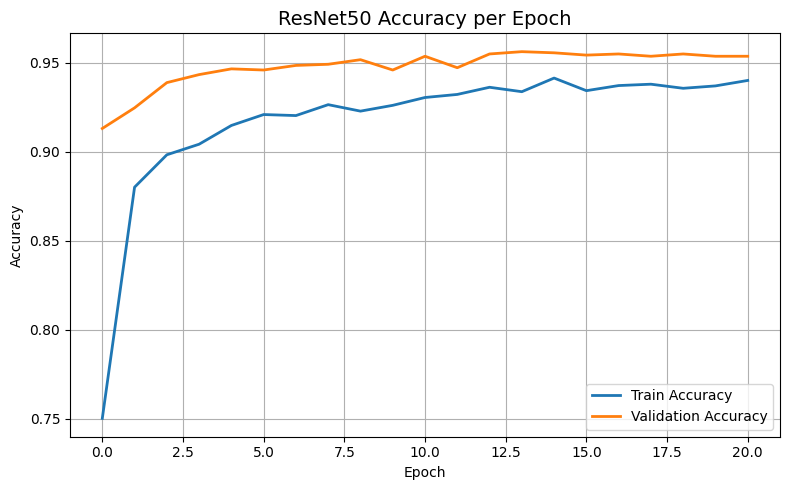

In [9]:
import matplotlib.pyplot as plt
import pickle

# ✅ Load training history for ResNet50
with open('/content/drive/MyDrive/TResNet50_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('ResNet50 Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


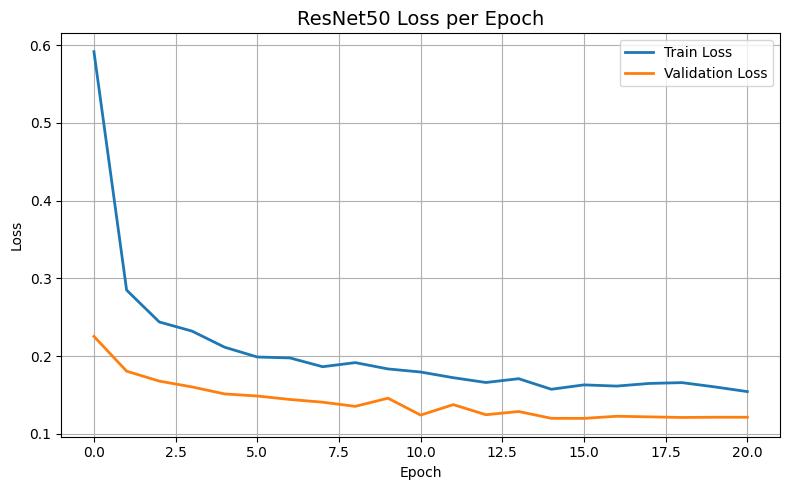

In [10]:
import matplotlib.pyplot as plt
import pickle

# ✅ Load training history for ResNet50
with open('/content/drive/MyDrive/TResNet50_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('ResNet50 Loss per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess  # ✅ ResNet50

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
final_model_path = '/content/drive/MyDrive/TResNet50_final.keras'  # ✅ Updated path for ResNet50
batch_size = 64
input_shape = (224, 224, 3)  # ✅ Input size for ResNet50

# -------- LOAD MODEL -------- #
model = load_model(final_model_path)

# -------- DATASET PREP -------- #
val_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# -------- EVALUATE -------- #
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Found 1556 images belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 11s/step - accuracy: 0.9613 - loss: 0.1250
✅ Test Accuracy: 95.95%
📉 Test Loss: 0.1166


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step
📊 Overall Model Performance (ResNet50, Threshold = 0.50):

✅ Accuracy :  0.9595
🎯 Precision: 0.9847
🔁 Recall   : 0.9597
📈 F1 Score : 0.9720


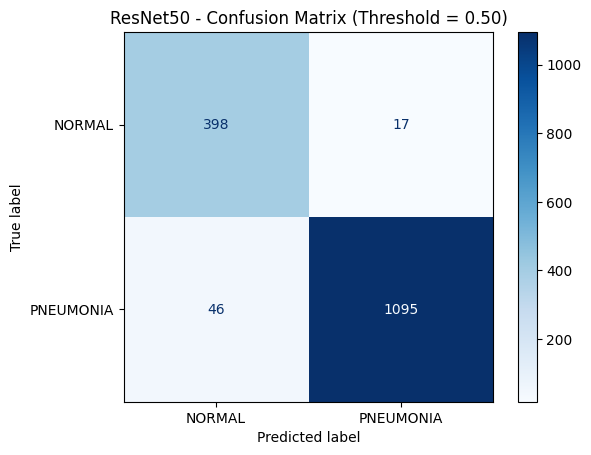


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1095
✅ True Negatives (TN): 398
❌ False Positives (FP): 17
❌ False Negatives (FN): 46


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# -------- Step 1: True labels from generator -------- #
y_true = test_generator.classes

# -------- Step 2: Model predictions -------- #
y_pred_probs = model.predict(test_generator, verbose=1)

# -------- Step 3: Apply threshold (e.g. 0.5) -------- #
threshold = 0.50
y_pred = (y_pred_probs > threshold).astype(int).reshape(-1)

# -------- Step 4: Metrics -------- #
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

# -------- Step 5: Print metrics -------- #
print("📊 Overall Model Performance (ResNet50, Threshold = 0.50):\n")
print(f"✅ Accuracy :  {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# -------- Step 6: Confusion Matrix -------- #
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # e.g. ['NORMAL', 'PNEUMONIA']

# -------- Step 7: Plot Confusion Matrix -------- #
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("ResNet50 - Confusion Matrix (Threshold = 0.50)")
plt.grid(False)
plt.show()

# -------- Step 8: TP, TN, FP, FN Breakdown -------- #
tn, fp, fn, tp = cm.ravel()

print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
